In [81]:
import time
import os
import random
import math

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

%matplotlib inline

In [82]:
assert os.environ['COLAB_GPU'], 'Make sure to select GPU from Edit > Notebook settings > Hardware accelerator'
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
!rm -f data
!ln -s '/content/drive/My Drive/proj2_data' data

#some utility

In [84]:
def collate_fn1(batch):
    return tuple(zip(*batch))

# define dataset

In [85]:
class MyDataset(Dataset):
    def __init__(self, datatype='train', transform=None):
        with open('data/bbox_'+datatype+'.csv') as f:
            id_to_box = dict()
            id_to_path = dict()
            id_to_turb= dict()
            last_name='none'
            idx=-1
            for line in f.read().splitlines():
                filename, wid, hei, turb, *box = line.split(',') # get all variable
                if turb =='severe turbulence':
                  turb_no=2
                else:
                  turb_no=1
                if filename == 'filename': # skip the title
                  continue

                if filename==last_name:
                  id_to_box[idx].append(list(map(float, box)))
                  id_to_turb[idx].append(turb_no)
                  
                else:
                  idx=idx+1
                  id_to_path[idx]=filename
                  id_to_box[idx]=[list(map(float, box))]
                  id_to_turb[idx]=[turb_no]
                  last_name=filename

            self.imgs = [(os.path.join('data/'+datatype, id_to_path[i]), id_to_box[i],id_to_turb[i])
                     for i in range(len(id_to_path))]

            #transform data
            self.target_transform = transforms.Compose([
                transforms.Resize((840, 840)),
                transforms.ToTensor()
            ])
            self.transform = transforms.Compose([
                self.target_transform,
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            if transform is not None:
                self.transform = transforms.Compose([
                    transform,
                    self.transform
                ])
                self.target_transform = transforms.Compose([
                    transform,
                    self.target_transform
                ])
                
    #Added by Shih-Yang,LIU
    #This prepare function calculate and store all the data needed for each image
    # data includes image itself, ground truth roi, ground truth class labels and proposed rois of each image
    # each element inside rois list is a tuple with first element being the coordinate of this roi in the foramte of (x1,y1,x2,y2)
    # Second element within the tuple is a dictionary that store the information of this specific RoI
    #{
    #  roi_dict = {
    #          "gt_box_iou_score": most_likely_gt_box_iou_score, ==> the iou score 
    #          "gt_index": most_likely_gt_index,
    #          "gt_box_coord": gt_box_coord,
    #          "gt_box_coord_xywh": gt_box_coord_xywh,
    #          "gt_box_class": gt_box_class
    #      }
    #}
    def prepare_data(self):
      

      self.data = []
      img_count = 1
      for img in self.imgs:
        # if img_count == 5:
        #   break
        print("processing image#: ", img_count)
        img_count = img_count+1
        path, box, turb = img
        im = (np.load(path))/292*255
        im=np.transpose(im,(1, 2, 0))
        im=np.uint8(im)
        boxes = np.array(box, dtype='int32')
        seed = np.random.randint(2147483647)
        random.seed(seed)
        torch.manual_seed(seed)
        PIL = transforms.ToPILImage()(im).convert('RGB')#if you want to output 4 dimension data, change to .convert('RGBA'). While you will not able to do transforms.Normalize()
        im = self.transform(PIL)

        v = genRoIsperImg(im, 10)


        proposed_roi_lable = []
        for i in v:
          IoU_list = []
          for gt_box in box:
            IoU = compute_IoU(i, gt_box)
            IoU_list.append(IoU)
          most_likely_gt_box_iou_score = max(IoU_list)
          most_likely_gt_index = IoU_list.index(most_likely_gt_box_iou_score)
          gt_box_coord = box[most_likely_gt_index]
          if most_likely_gt_box_iou_score > 0:
            gt_box_class = turb[most_likely_gt_index]
          else:
            gt_box_class = 0
          
          gt_box_coord_xywh = np.array([gt_box_coord[0],gt_box_coord[1],gt_box_coord[2]-gt_box_coord[0],gt_box_coord[3]-gt_box_coord[1]])



          roi_dict = {
              "gt_box_iou_score": most_likely_gt_box_iou_score,
              "gt_index": most_likely_gt_index,
              "gt_box_coord": gt_box_coord,
              "gt_box_coord_xywh": gt_box_coord_xywh,
              "gt_box_class": gt_box_class
          }

          proposed_roi_lable.append([i,roi_dict])

        self.data.append([im, box, turb, proposed_roi_lable])

          # print(most_likely_gt_box_iou_score, most_likely_gt_index, gt_box_coord, gt_box_class)




    def __getitem__(self, index):
      return self.data[index]

    def __len__(self):
        return len(self.imgs)

# dataloader

In [86]:
test = torch.load('/content/data/test.pt')
test_dataloader = torch.utils.data.DataLoader(test,batch_size=2,shuffle=False,collate_fn=collate_fn1)

#Data visulize

In [87]:
def imshow(img, gt_box, turb_type,pred_box=None,VMIN=0.77):#vmin is the minimum color threhold, since our color too light, we should increase the vmin
    img=np.uint8(img*255)
    PIL_img=transforms.ToPILImage()(img).convert('RGB')
    grayscale_image = PIL_img.convert("L")
    grayscale_array = np.asarray(grayscale_image)/255
    print(grayscale_array.shape)
    imgplot = plt.imshow(grayscale_array, cmap="gray",vmin=VMIN)
    
    def draw_box(box, turb_type):
        x1, y1, x2, y2 = box
        if x1 == 0:
            x1 = 1
        if y1 == 0:
            y1 = 1
        if x2 >= 840:
          x2 = 839
        if y2 >= 840:
          y2 = 839
        if turb_type==2:
          color='red'
        else:
          color='green'
        plt.gca().add_patch(
            plt.Rectangle((x1, y1), x2-x1, y2-y1,
                          fill=False, edgecolor=color, linewidth=2, alpha=0.5)
        )
    for i in range(len(box)):
      draw_box(box[i],turb_type[i])
    if pred_box is not None:
        draw_box(pred_box, 'blue')
    plt.plot()

(840, 840)


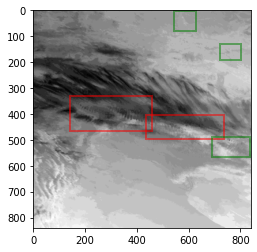

In [90]:
dataset=test_dataloader.dataset
im, box, turb, rois = dataset[4]

inp = im.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
imshow(inp, box,turb,VMIN=0.76) #select VMIN from 0.7-0.8

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

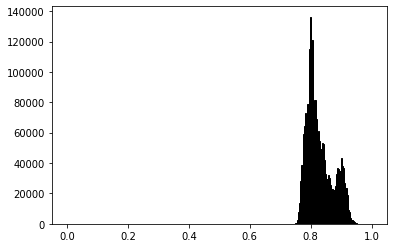

In [89]:
plt.hist(inp.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')